In [3]:
#imports
import torch

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [6]:
#definim transformarea imaginilor
img_size = 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize (ResNet standard)
])

In [7]:
#definim directoarele:
train_dir = "D:\Facultate\Licenta\DatasetTrim\Train"
valid_dir = "D:\Facultate\Licenta\DatasetTrim\Validation"
test_dir = "D:\Facultate\Licenta\DatasetTrim\Test"

In [8]:
train_dataset = ImageFolder(root=train_dir, transform=transform)
valid_dataset = ImageFolder(root=valid_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

In [9]:
#Creating DataLoaders - efficiently load batches of images during training.
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [10]:
#Load Pretrained ResNet Model
model = models.resnet50(pretrained=True)

# Modify the classifier for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

#Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer and scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [9]:
layout = {
    "Resnet50": {
        "Loss": ["Multiline", ["Loss/Train", "Loss/Validation"]],
        "Accuracy": ["Multiline", ["Accuracy/Train", "Accuracy/Validation"]],
        "Learning_Rate": ["Line", ["Learning Rate"]]
    },
}
writer = SummaryWriter()
writer.add_custom_scalars(layout)
#log_dir="D:\Facultate\Licenta\ResNet_Detection\runs"

num_epochs = 20
early_stop_patience = 5  # Stop if no improvement after 5 epochs
no_improve_epochs = 0
best_val_loss = float("inf")

# Store values for later analysis
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

#Training phase
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct_preds = 0  # Track correct training predictions
    train_total_samples = 0  # Total training samples

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute training accuracy
        preds = torch.sigmoid(outputs) > 0.5
        train_correct_preds += (preds == labels).sum().item()
        train_total_samples += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_accuracy = (train_correct_preds / train_total_samples) * 100
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    val_accuracy = (correct_preds / total_samples) * 100
    val_accuracies.append(val_accuracy)

    # Log values to TensorBoard
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)
    writer.add_scalar("Learning Rate", optimizer.param_groups[0]['lr'], epoch)

    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # Reduce LR if validation loss stops improving
    scheduler.step(avg_val_loss)

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_resnet50.pth")
        print("✅ Model Saved!")
    else:
        no_improve_epochs += 1
        print(f"⚠️ No improvement for {no_improve_epochs}/{early_stop_patience} epochs.")

    if no_improve_epochs >= early_stop_patience:
        print("⏹ Early stopping triggered! Training stopped.")
        break

print("🎉 Training complete!")
writer.close()

Epoch [1/20] | Train Loss: 0.2634 | Train Acc: 89.41% | Val Loss: 0.1814 | Val Acc: 92.68%
✅ Model Saved!
Epoch [2/20] | Train Loss: 0.0723 | Train Acc: 97.45% | Val Loss: 0.1693 | Val Acc: 93.65%
✅ Model Saved!
Epoch [3/20] | Train Loss: 0.0353 | Train Acc: 98.96% | Val Loss: 0.1638 | Val Acc: 94.43%
✅ Model Saved!
Epoch [4/20] | Train Loss: 0.0197 | Train Acc: 99.51% | Val Loss: 0.1877 | Val Acc: 94.24%
⚠️ No improvement for 1/5 epochs.
Epoch [5/20] | Train Loss: 0.0126 | Train Acc: 99.67% | Val Loss: 0.2371 | Val Acc: 93.46%
⚠️ No improvement for 2/5 epochs.
Epoch [6/20] | Train Loss: 0.0081 | Train Acc: 99.79% | Val Loss: 0.1805 | Val Acc: 95.12%
⚠️ No improvement for 3/5 epochs.
Epoch [7/20] | Train Loss: 0.0056 | Train Acc: 99.91% | Val Loss: 0.1946 | Val Acc: 94.34%
⚠️ No improvement for 4/5 epochs.
Epoch [8/20] | Train Loss: 0.0040 | Train Acc: 99.92% | Val Loss: 0.1928 | Val Acc: 94.73%
⚠️ No improvement for 5/5 epochs.
⏹ Early stopping triggered! Training stopped.
🎉 Training 

In [11]:
model.load_state_dict(torch.load("Model_v1.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).squeeze()
        preds = torch.sigmoid(outputs) > 0.5

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

C:\Users\ALex\AppData\Local\Temp\ipykernel_12688\1772586048.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Model_v1.pth"))


Test Accuracy: 83.01%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


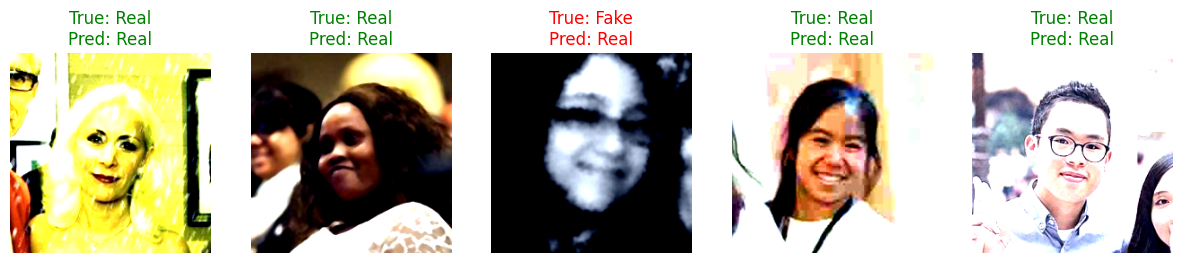

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random

random_indices = random.sample(range(len(test_dataset)), 5)

fig, axes = plt.subplots(1, 5, figsize=(15,5))

for i, idx in enumerate(random_indices):
    image, true_label = test_dataset[idx]
    pred_label = all_preds[idx]  # Retrieve stored prediction

    # Convert image tensor to NumPy for plotting
    image = image.numpy().transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)
    image = image * 0.5 + 0.5  # Unnormalize (assuming normalization was used)

    # Convert labels to "Real" or "Fake"
    true_label_str = "Real" if true_label == 1 else "Fake"
    pred_label_str = "Real" if pred_label == 1 else "Fake"

    # Set title color: green (correct) or red (incorrect)
    color = "green" if true_label == pred_label else "red"

    # Display image
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"True: {true_label_str}\nPred: {pred_label_str}", color=color)

plt.show()